# Image caption generator

## Part 1 - seq2seq auto encoder

In [1]:
from fastai.text import *
import pandas as pd
from pathlib import Path
from PIL import Image

In [2]:
gpu = torch.device('cuda:0')

In [3]:
PATH = Path('data/')
PATH.mkdir(exist_ok=True)

In [4]:
seq_PATH = PATH/'seq2deq_model'
seq_PATH.mkdir(exist_ok=True)

In [5]:
captions_and_links_valid = pd.read_csv("Validation_GCC-1.1.0-Validation.tsv", sep="\t",header=None)
captions_and_links_train = pd.read_csv("Train_GCC-training.tsv", sep="\t",header=None)

In [6]:
len(captions_and_links_valid), len(captions_and_links_train)

(15840, 3318333)

In [6]:
captions_and_links_valid.head()

,0,1
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...
1,an angler fishes river on a snowy day .,http://www.standard.net/image/2015/02/04/800x_...
2,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...
3,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...
4,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...


In [7]:
captions_valid = captions_and_links_valid[0].values
captions_train = captions_and_links_train[0].values

In [8]:
len(captions_train), len(captions_valid)

(3318333, 15840)

### Tokenization

In [5]:
tokenizer = Tokenizer()

In [10]:
tokens_captions_valid = tokenizer.process_all(captions_valid)s

In [11]:
tokens_captions_train = tokenizer.process_all(captions_train)

**Let's make sure everything went right:**

In [12]:
print(captions_train[777], ' '.join(tokens_captions_train[777]))

people click into their skis . people click into their skis .


### Length of captions
#### Average length of captions

In [13]:
np.mean([len(c) for c in tokens_captions_valid])

10.415467171717172

In [14]:
np.mean([len(c) for c in tokens_captions_train])

10.322056888202601

#### Discard captions that are too long

In [15]:
tokens_captions_valid = np.array(tokens_captions_valid)[np.array([len(c) < 30 for c in tokens_captions_valid])]

In [16]:
np.max([len(c) for c in tokens_captions_valid])

29

In [17]:
tokens_captions_train = np.array(tokens_captions_train)[np.array([len(c) < 30 for c in tokens_captions_train])]

In [18]:
np.max([len(c) for c in tokens_captions_train])

29

In [19]:
pickle.dump((tokens_captions_valid), (seq_PATH/'tok_cap_v.pkl').open('wb'))

In [20]:
pickle.dump((tokens_captions_train), (seq_PATH/'tok_cap_t.pkl').open('wb'))

In [177]:
tokens_captions_valid = pickle.load((seq_PATH/'tok_cap_v.pkl').open('rb'))

In [178]:
tokens_captions_train = pickle.load((seq_PATH/'tok_cap_t.pkl').open('rb'))

In [179]:
print(len(tokens_captions_train), len(tokens_captions_valid))

3302516 15764


### Numericalization

In [8]:
vocab = Vocab.create(tokens_captions_train, max_vocab=50000, min_freq=2)

In [120]:
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [180]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

**Let's quickly test this:**

In [9]:
idx = 12575

In [10]:
test_caption = tokens_captions_valid[idx]
print(' '.join(w for w in test_caption))

actor attending the world premiere of crime fiction film


In [11]:
test_caption_num = vocab.numericalize(test_caption)
print(test_caption_num)

[31, 1841, 8, 108, 43, 11, 2274, 1018, 76]


In [12]:
print(vocab.textify(test_caption_num))

actor attending the world premiere of crime fiction film


In [13]:
tokens_captions_valid[0]

['author', ':', 'a', 'life', 'in', 'photography', '--', 'in', 'pictures']

In [181]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

In [182]:
captions_numericalized_valid = numericalize_tokens(tokens_captions_valid)

In [183]:
captions_numericalized_train = numericalize_tokens(tokens_captions_train)

Test it:

In [12]:
vocab.textify(captions_numericalized_train[1256339])

'a vector illustration of a motorcycle contrasted against a bicycle . xxpad'

### Word vectors

In [34]:
#! pip install git+https://github.com/facebookresearch/fastText.git

In [35]:
import fastText as ft

In [36]:
en_vecs = ft.load_model(str(seq_PATH/'wiki.en.bin'))

In [37]:
vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [38]:
pickle.dump(vec_dict, open(seq_PATH/'vec_dict.pkl', 'wb'))

In [184]:
vec_dict = pickle.load(open(seq_PATH/'vec_dict.pkl','rb'))

**Let's take a look at the most frequent words from fastText:**

In [40]:
ft_words = en_vecs.get_words(include_freq=True)

In [41]:
ft_word_dict = {k:v for k,v in zip(*ft_words)}

In [42]:
ft_words = sorted(ft_word_dict.keys(), key=lambda x: ft_word_dict[x])

10 most frequent words:

In [43]:
ft_words[-10:]

[')', "'", 'and', 'in', '-', 'of', '</s>', 'the', '.', ',']

**Mean and stdv of the word vectors:**

In [44]:
vecs = np.stack(list(vec_dict.values()))

In [45]:
vecs.mean(), vecs.std()

(0.0075652334, 0.29283327)

### Dataset

In [185]:
def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

In [186]:
class Caption2CaptionDataset(Dataset):
    def __init__(self, x):
        self.x = x
    def __getitem__(self, idx):
        return A(self.x[idx], self.x[idx])
    def __len__(self):
        return len(self.x)

In [187]:
trn_ds = Caption2CaptionDataset(captions_numericalized_train)

In [188]:
val_ds = Caption2CaptionDataset(captions_numericalized_valid)

In [17]:
len(trn_ds), len(val_ds)

(3302516, 15764)

In [18]:
vocab.textify(trn_ds[0][0])

'a very typical bus station xxpad'

### Dataloader

In [189]:
bs = 125

In [190]:
val_sampler = SortSampler(captions_numericalized_valid, key=lambda x:len(captions_numericalized_valid[x]))

trn_sampler = SortishSampler(captions_numericalized_train, key=lambda x: len(captions_numericalized_train[x]), bs=bs)

Since we want to fully utilize the GPUs capabilities, we train in batches. The length of a minibatch tensor is set by the sequence length of the longest question in that batch. The other questions are padded. To save time and memory, we want to avoid very long and very short questions in one batch because that would mean lot's of padding. For the validation set we simply sort the questions. For training we use the `SortishSampler` which groups *longer* questions together and *shorter* questions together while preserving some randomness.

For language models it's better to pad before the start of the sequence because we need the final hidden state to predict the next token or for classification...

For sequence to sequence models it is better to pad after the end of the sequence.

The samplers return an index:

In [20]:
i = next(iter(trn_sampler))

In [21]:
vocab.textify(captions_numericalized_train[i])

'would you have thought that the sun is so orange if you had only seen the lower buildings ? does this influence how you see the white surfaces ? xxpad'

In [39]:
import pdb

In [191]:
def pad_collate_seq2seq(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_inp = max([len(s[0]) for s in samples])
    max_len_out = max([len(s[1]) for s in samples])
    
    res_inp = torch.zeros(len(samples), max_len_inp).long() + pad_idx
    res_out = torch.zeros(len(samples), max_len_out).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_inp[i,-len(s[0]):] = LongTensor(s[0])
            res_out[i,-len(s[1]):] = LongTensor(s[1])
        else:         
            res_inp[i,:len(s[0]):] = LongTensor(s[0])  # TK
            res_out[i,:len(s[1]):] = LongTensor(s[1])
    if backwards:
        res = res.flip(1)
    if transpose:
        res_inp.transpose_(0,1)
        res_out.transpose_(0,1)
    return res_inp, res_out

In [192]:
my_pad_collate_func = partial(pad_collate_seq2seq, pad_first=False, transpose=True)

In [193]:
trn_dl = DataLoader(dataset=trn_ds, batch_size=bs, sampler=trn_sampler, collate_fn=my_pad_collate_func)

In [194]:
val_dl = DataLoader(dataset=val_ds, batch_size=bs, sampler=val_sampler, collate_fn=my_pad_collate_func)

Let's test the dataloader:

In [27]:
it = iter(val_dl)

In [28]:
its = [next(it) for _ in range(3)]

In [29]:
[(x.shape, y.shape) for x, y in its]

[(torch.Size([30, 125]), torch.Size([30, 125])),
 (torch.Size([27, 125]), torch.Size([27, 125])),
 (torch.Size([24, 125]), torch.Size([24, 125]))]

In [38]:
for x, y in its:
    print(vocab.textify(x[:,100]))
    print(vocab.textify(y[:,100]))
    print()

this is an old photo of my figure i had and i slightly edited it and now he looks like he 's from a dramatic anime xxpad xxpad xxpad xxpad
this is an old photo of my figure i had and i slightly edited it and now he looks like he 's from a dramatic anime xxpad xxpad xxpad xxpad

i have no idea how that american flag got in this picture of the construction , but i love that it is there ! xxpad xxpad xxpad
i have no idea how that american flag got in this picture of the construction , but i love that it is there ! xxpad xxpad xxpad

detail shot : the hands of a woman driving a car by the countryside , seen from the front passenger 's seat xxpad xxpad
detail shot : the hands of a woman driving a car by the countryside , seen from the front passenger 's seat xxpad xxpad



### Model

In [195]:
n_hid, n_layers = 400, 3

In [196]:
def create_emb(wordvecs, itos, emb_sz):
    emb= nn.Embedding(len(itos), emb_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [205]:
class seq2seqAutoEncoder(nn.Module):
    def __init__(self, device, wordvecs, itos, emb_sz, n_hid, out_seqlen, n_layers=2):
        super().__init__()
        self.n_hid, self.n_layers, self.out_seqlen = n_hid, n_layers, out_seqlen
        self.device = device
        
        # Encoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.emb = self.emb.to(self.device)
        self.emb_drop = nn.Dropout(0.15)
        self.rnn_enc = nn.GRU(emb_sz, n_hid, num_layers=n_layers, dropout=0.25)
        self.output_enc = nn.Linear(n_hid, emb_sz, bias=False)
        
        # Decoder
        self.rnn_dec = nn.GRU(emb_sz, emb_sz, num_layers=n_layers, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        
    def forward(self, inp):
        #pdb.set_trace()
        _, h = self.encode(inp)
        
        dec_inp = torch.zeros(inp.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        
        for i in range(self.out_seqlen):
            dec_output, h = self.decode(dec_inp, h)
            res.append(dec_output)
            dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
        
        return torch.stack(res)
    
    def encode(self, inp):
        h = self.initHidden(inp.size(1))  # bs
        h = h.to(self.device)
        emb = self.emb_drop(self.emb(inp))
        enc_output, h = self.rnn_enc(emb, h) # h[1] is same as enc_outp[-1]!
        
        h = self.output_enc(h)
        
        return enc_output, h
    
    def decode(self, dec_inp, h):
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
        output, h = self.rnn_dec(emb_inp, h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h
    
    def initHidden(self, bs):
        return torch.zeros(self.n_layers, bs, self.n_hid, requires_grad=False)

In [206]:
def Seq2SeqLoss(pred, target):
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    return F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))

In [207]:
emb_sz = vec_dict["cat"].size
emb_sz

300

In [208]:
rnn = seq2seqAutoEncoder(gpu, vec_dict, vocab.itos, emb_sz, n_hid, 30, n_layers)
rnn = rnn.to(gpu)

3689 ['xxup', 'xxrep', 'xxwrep', ':', "'s"]


In [209]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [210]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=seq_PATH, collate_fn=my_pad_collate_func)

In [211]:
learn = Learner(data=dataBunch, model=to_device(rnn, gpu), opt_func=opt_fn, loss_func=Seq2SeqLoss, callback_fns=ShowGraph)

In [212]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


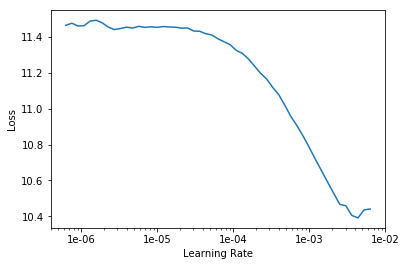

In [214]:
learn.recorder.plot(skip_end=15)

In [38]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(1, lr)

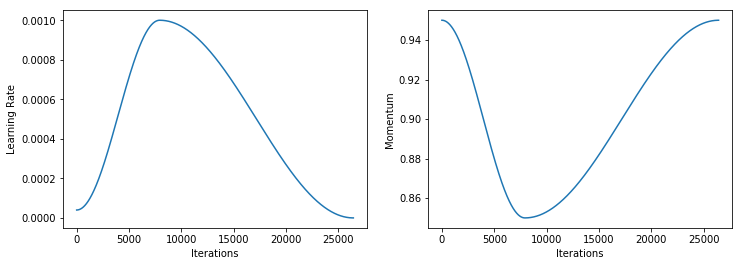

In [421]:
learn.recorder.plot_lr(show_moms=True)

In [422]:
#learn.save("GRU_try1")

In [221]:
learn.load("GRU_try1")

/home/fabiograetz/anaconda3/envs/imgcap/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type seq2seqAutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=DataBunch;

Train: <__main__.Caption2CaptionDataset object at 0x7f0800efd080>;

Valid: <__main__.Caption2CaptionDataset object at 0x7f0800efd908>;

Test: None, model=seq2seqAutoEncoder(
  (emb): Embedding(33465, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (rnn_enc): GRU(300, 400, num_layers=3, dropout=0.25)
  (output_enc): Linear(in_features=400, out_features=300, bias=False)
  (rnn_dec): GRU(300, 300, num_layers=3, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=33465, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.8, 0.99)), loss_func=<function Seq2SeqLoss at 0x7f09758a4730>, metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('data/seq2deq_model'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True), <class 'fastai.train.ShowGraph'>], callbacks=[], layer_groups=[Sequential(
  (0): Embedding(33465, 300, paddin

In [222]:
learn.model.state_dict().keys()

odict_keys(['emb.weight', 'rnn_enc.weight_ih_l0', 'rnn_enc.weight_hh_l0', 'rnn_enc.bias_ih_l0', 'rnn_enc.bias_hh_l0', 'rnn_enc.weight_ih_l1', 'rnn_enc.weight_hh_l1', 'rnn_enc.bias_ih_l1', 'rnn_enc.bias_hh_l1', 'rnn_enc.weight_ih_l2', 'rnn_enc.weight_hh_l2', 'rnn_enc.bias_ih_l2', 'rnn_enc.bias_hh_l2', 'output_enc.weight', 'rnn_dec.weight_ih_l0', 'rnn_dec.weight_hh_l0', 'rnn_dec.bias_ih_l0', 'rnn_dec.bias_hh_l0', 'rnn_dec.weight_ih_l1', 'rnn_dec.weight_hh_l1', 'rnn_dec.bias_ih_l1', 'rnn_dec.bias_hh_l1', 'rnn_dec.weight_ih_l2', 'rnn_dec.weight_hh_l2', 'rnn_dec.bias_ih_l2', 'rnn_dec.bias_hh_l2', 'out.weight', 'out.bias'])

In [223]:
torch.save(learn.model.state_dict(), PATH/"seq2seqAutoencoderStateDict.pth")

### Let's try the model

In [45]:
learn.model.train()

seq2seqAutoEncoder(
  (emb): Embedding(33465, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (rnn_enc): GRU(300, 400, num_layers=3, dropout=0.25)
  (output_enc): Linear(in_features=400, out_features=300, bias=False)
  (rnn_dec): GRU(300, 300, num_layers=3, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=33465, bias=True)
)

In [37]:
learn.model.eval()

seq2seqAutoEncoder(
  (emb): Embedding(33465, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (rnn_enc): GRU(300, 400, num_layers=3, dropout=0.25)
  (output_enc): Linear(in_features=400, out_features=300, bias=False)
  (rnn_dec): GRU(300, 300, num_layers=3, dropout=0.1)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=300, out_features=33465, bias=True)
)

## Beamsearch

Watch this [video](https://www.youtube.com/watch?v=RLWuzLLSIgw) (and the following two in the series) for a good explanation.

The original beam-search strategy finds a translation
that approximately maximizes the conditional
probability given by a specific model. It builds
the translation from left-to-right and keeps a fixed
number (beam) of translation candidates with the
highest log-probability at each time step. For each
end-of-sequence symbol that is selected among
the highest scoring candidates the beam is reduced
by one and the translation is stored into a final candidate
list. When the beam is zero, it stops the
search and picks the translation with the highest
log-probability (normalized by the number of target
words) out of the final candidate list.

[Source](https://www.aclweb.org/anthology/W17-3207)

In [38]:
class HypothesisNode():
    """ Hypothesis Node class for performing Beam Search """
    def __init__(self, sequence, log_prob, hidden_state):
        """HypothesisNode constructur
        
        Args:
          sequence: A sequence of tokens
          log_prob: The log of the probability of this sequence
          hidden_state: The hidden state of the Decoder RNN after decoding the last token in the sequence
        """
        self._seq = sequence
        self._log_prob = log_prob
        self._h = hidden_state
    
    @property
    def last_tok(self):
        """
        Returns:
          The last token in the sequence
        """
        return self._seq[-1]
        
    def update(self, tok, log_prob, new_h):
        """
        Updates the sequence with a new token and returns a new Hypothesis Node
        Args:
          tok: The new token that is appended to the sequence
          log_prob: The log of the probability ot this token
          new_h: The new hidden state of the Decoder RNN after this token
        
        Returns:
          An Hypothesis Node with the updated sequence, log probability and hidden state
        """
        return HypothesisNode(self._seq + [tok], self._log_prob + log_prob, new_h)
    
    def __str__(self):
        return ('Hyp(log_p = %4f,\t seq = %s)' % (self._log_prob, vocab.textify([t.item()for t in self._seq])))

In [39]:
class BeamSearch():
    """ Performs BeamSearch for seq2seq decoding or Image captioning """
    def __init__(self, enc_model, dec_model, beam_width, max_len):
        """BeamSearch object constructor
        Args:
          enc_model: A seq2seq encoder or cnn for image captioning
          dec_model: A RNN decoder model
          beam_width: int, the number of hypotheses to remember in each iteration
          max_len: int, the longest possible sequence
        """
        self._enc_model = enc_model
        self._dec_model = dec_model
        self._beam_width = beam_width
        self._max_len = max_len
        self._start_tok = 0
        self._end_tok   = 1
        
    def search(self, inp_seq, verbose=False):
        """Performs the Beam search
        Args:
          inp_seq: the input sequence to be encoded
          verbose: bool, allows printing the intermediate hypotheses for better understanding
        
        Returns:
          The 'beam_width' most probable sentences
        """
        inp_seq = torch.tensor(inp_seq).unsqueeze(0).transpose_(0,1).cuda()
        _, h = self._enc_model(inp_seq)

        hyps = [HypothesisNode([torch.zeros(1, requires_grad=False).long().cuda()], 0, h)]
        results = []
        
        step = 0
        width = self._beam_width
        while width > 0 and step < self._max_len:
            if verbose: print("\n Step: ",step)
            new_hyps = []
            for h in hyps:
                new_hyps.extend(self.get_next_hypotheses(h, width))
            
            new_hyps = sorted(new_hyps, key= lambda x: x._log_prob, reverse=True)
            if verbose: self.print_hypotheses(new_hyps, "Before narrowing:")
                
            hyps = []
            for h in new_hyps[:width]:
                if h.last_tok == self._end_tok:
                    results.append(h)
                    width = width - 1
                else:
                    hyps.append(h)
            
            if verbose: 
                self.print_hypotheses(hyps, "After narrowing:")
                self.print_hypotheses(results, "Results:")
                
            step += 1
         
        results.extend(hyps[:width])
        results = sorted(results, key=lambda x: x._log_prob/len(x._seq), reverse=True)
        
        if verbose: self.print_hypotheses(results, "Final:")
        
        return [[t.item() for t in r._seq[1:]] for r in results]
        
    def get_next_hypotheses(self, hyp, k):
        """Calculates the next 'beam_width' hypotheses given a Hypothesis Node
        Args:
          hyp: an Hypothesis Node containing a sequence, a log probability and a Decoder RNN hidden state
          k: the number of hypotheses to calculate
        Returns:
          A list with the 'beam_width' most probable sequences/Hypothesis Nodes
        """

        dec_outp, h = self._dec_model(hyp.last_tok, hyp._h)

        top_k_log_probs, top_k_toks = dec_outp.topk(k, dim=1)
        
        return [hyp.update(top_k_toks[0][i].unsqueeze(0), top_k_log_probs[0][i], h) for i in range(k)]
    
    def print_hypotheses(self, hyps, description):
        print(description)
        for h in hyps:
            print(h)

In [40]:
BeamSearcher = BeamSearch(learn.model.encode, learn.model.decode, 5, 30)

In [41]:
def show_random_val_prediction(idx:int):
    print(idx)
    data = learn.data.valid_ds[idx][0]
    results = BeamSearcher.search(data, True)

    print("\nlabel\t",vocab.textify(data))
    data = torch.tensor(data).unsqueeze(0).transpose_(0,1).cuda()
    res = learn.model((data))
    res = res.data.max(2)[1]
    res = res.transpose_(0,1).data.cpu().numpy()
    print("greedy\t",vocab.textify(res[0]))

    print("beam\t",vocab.textify(results[0]))
    #return (vocab.textify(data),vocab.textify(res[0]) ,vocab.textify(results[0]))

In [43]:
show_random_val_prediction(1495)

1495

 Step:  0
Before narrowing:
Hyp(log_p = 0.000000,	 seq = xxunk automotive)
Hyp(log_p = -17.802856,	 seq = xxunk industry)
Hyp(log_p = -23.518724,	 seq = xxunk automobile)
Hyp(log_p = -25.705811,	 seq = xxunk retail)
Hyp(log_p = -25.719061,	 seq = xxunk manufacturing)
After narrowing:
Hyp(log_p = 0.000000,	 seq = xxunk automotive)
Hyp(log_p = -17.802856,	 seq = xxunk industry)
Hyp(log_p = -23.518724,	 seq = xxunk automobile)
Hyp(log_p = -25.705811,	 seq = xxunk retail)
Hyp(log_p = -25.719061,	 seq = xxunk manufacturing)
Results:

 Step:  1
Before narrowing:
Hyp(log_p = 0.000000,	 seq = xxunk automotive industry)
Hyp(log_p = -15.081491,	 seq = xxunk automotive automotive)
Hyp(log_p = -17.802856,	 seq = xxunk industry industry)
Hyp(log_p = -18.482037,	 seq = xxunk automotive business)
Hyp(log_p = -19.633089,	 seq = xxunk automotive wine)
Hyp(log_p = -19.914619,	 seq = xxunk automotive music)
Hyp(log_p = -23.518724,	 seq = xxunk automobile industry)
Hyp(log_p = -25.705811,	 seq = xxu

## Part 2 - Image caption generator
### Image caption dataset

In [7]:
TRAIN_PATH_FULL = Path("/media/fabiograetz/data_storage/image_captions/data")

In [8]:
TRAIN_PATH_SUBSET = PATH/"train"
TRAIN_PATH_SUBSET.mkdir(exist_ok=True)
(TRAIN_PATH_SUBSET/"pics").mkdir(exist_ok=True)

In [9]:
VALID_PATH = PATH/"valid"
VALID_PATH.mkdir(exist_ok=True)

In [30]:
def load_partial_dicts(PATH):
    combined_dict = dict()
    for fn in PATH.iterdir():
        if str(fn)[-3:] == "pkl":
            combined_dict.update(pickle.load(fn.open('rb')))
    pickle.dump(combined_dict, open(PATH/'caption_dict.pkl', 'wb'))

In [10]:
def show_training_pair(PATH, caption_dict, idx):
    fn, caption = caption_dict[idx]
    img = Image.open(PATH/"downloadedPics"/fn)
    plt.imshow(img)
    print(caption)

#### Examples from the validation dataset:

In [ ]:
load_partial_dicts(VALID_PATH)

In [13]:
valid_dict = pickle.load((VALID_PATH/"caption_dict.pkl").open('rb'))

clouds running over mountain view in the morning


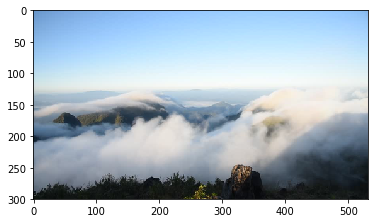

In [14]:
show_training_pair(VALID_PATH, valid_dict, 2900)

seals lie on a glacier and rest .


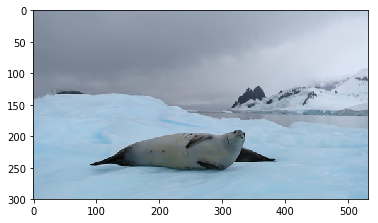

In [15]:
show_training_pair(VALID_PATH, valid_dict, 13900)

#### Examples from the train dataset:

In [47]:
load_partial_dicts(TRAIN_PATH_FULL)

In [19]:
train_dict_full = pickle.load((TRAIN_PATH_FULL/"caption_dict.pkl").open('rb'))

puppy sits proudly in front of a flag .


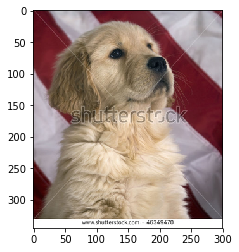

In [20]:
show_training_pair(TRAIN_PATH_FULL, train_dict_full, 3112900)

biological genus growing on step up to an old wooden door in a garden wall


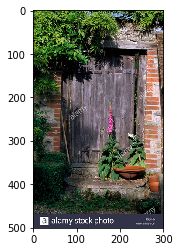

In [21]:
show_training_pair(TRAIN_PATH_FULL, train_dict_full, 178031)

#### Construct a subset of the  training set for experimentation (the full dataset is ~600GB)

In [91]:
from shutil import copyfile

In [90]:
def create_subset(sz):
    subset_indxs = random.sample(range(0, len(train_dict_full)), sz)
    subset_dict = dict()
    for idx in subset_indxs:
        if idx in train_dict_full:
            copyfile(TRAIN_PATH_FULL/"downloadedPics"/"{}.png".format(idx), TRAIN_PATH_SUBSET/"downloadedPics"/"{}.png".format(idx))
            subset_dict[idx] = train_dict_full[idx]
    pickle.dump(subset_dict, open(TRAIN_PATH_SUBSET/'caption_dict.pkl', 'wb'))

In [115]:
create_subset(100000)

In [22]:
train_dict_subset = pickle.load((TRAIN_PATH_SUBSET/"caption_dict.pkl").open('rb'))

### Define custom Dataset class and collate_fn

In [235]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
ImageFile.LOAD_TRUNCATED_IMAGES = True

The last line is crucial as some of the images have too large metadata and PIL throws the Exception `ValueError: Decompressed Data Too Large` (see [here](https://stackoverflow.com/questions/42671252/python-pillow-valueerror-decompressed-data-too-large)).

In [236]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

In [25]:
def build_data(captions_dict, PATH):
    filenames, captions = zip(*list(captions_dict.values()))
    filenames = list(map(lambda x: str(PATH/"downloadedPics") +"/" + x,filenames))
    captions = tokenizer.process_all(captions)
    captions_tok = numericalize_tokens(captions)
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(PATH/"dataset.pkl", 'wb'))

In [108]:
build_data(valid_dict, VALID_PATH)
build_data(train_dict_subset, TRAIN_PATH_SUBSET)

In [113]:
build_data(train_dict_full, TRAIN_PATH_FULL)

In [237]:
valid_data = pickle.load((VALID_PATH/"dataset.pkl").open('rb'))
train_data = pickle.load((TRAIN_PATH_SUBSET/"dataset.pkl").open('rb'))

In [27]:
train_data_full = pickle.load((TRAIN_PATH_FULL/"dataset.pkl").open('rb'))

In [238]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # There are grayscale images in dataset and tensor shapes have to match except in dim=0
        image = Image.open(self.filenames[idx]).convert('RGB')
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

In [239]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return torch.stack(images, 0, out=None), res_cap

In [240]:
imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

#### Get mean and stdv

Taken from [here](https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/9).

In [153]:
tfms = transforms.Compose([
    transforms.CenterCrop(300),
    transforms.ToTensor()
])

In [111]:
train_dataset_subset = ImageCaptionDataset(train_data, transform=tfms)

In [112]:
len(train_dataset_subset)

91362

In [113]:
loader = DataLoader(train_dataset_subset, batch_size=56, num_workers=1, shuffle=False, collate_fn=imgcap_collate_func)

In [165]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for idx,data in enumerate(loader):
        data = data[0]
        b, c, h, w = data.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(data, dim=[0, 2, 3])
        sum_of_square = torch.sum(data ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels
        if idx % 100 == 0:
            print(idx/(len(train_dataset_subset)/56))

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [ ]:
mean, std = online_mean_and_sd(loader)

In [34]:
mean, std = tensor([0.5238, 0.5003, 0.4718]), tensor([0.3159, 0.3091, 0.3216])

### Build the datasets

In [241]:
tfms = transforms.Compose([
    transforms.Resize(140),
    #transforms.RandomRotation(10, expand=False),
    transforms.CenterCrop(140),
    #transforms.RandomCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718],[0.3159, 0.3091, 0.3216])
])

In [242]:
inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

In [243]:
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

In [244]:
valid_dataset = ImageCaptionDataset(valid_data, transform=tfms)

In [245]:
train_dataset = ImageCaptionDataset(train_data, transform=tfms)

In [557]:
train_dataset_full = ImageCaptionDataset(train_data_full, transform=tfms)

In [558]:
print(
    "Valid dataset: {}\nTrain dataset: {}\nTrain dataset full: {}".format(len(valid_dataset), len(train_dataset), len(train_dataset_full))
)

Valid dataset: 14256
Train dataset: 91362
Train dataset full: 3035015


**Quick test:**

person standing at the beach vector art illustration xxpad


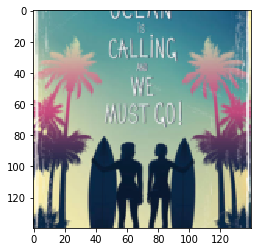

In [21]:
idx = 33085
d = train_dataset
img, cap = d[idx]
print(vocab.textify(cap))
plt.imshow(denorm(img))

### Build the dataloaders

In [380]:
bs = 56

In [381]:
val_sampler = SortSampler(valid_data[1], key=lambda x:len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)

In [248]:
trn_sampler_full = SortishSampler(train_data_full[1], key=lambda x: len(train_data_full[1][x]), bs=bs)

NameError: name 'train_data_full' is not defined

In [382]:
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func)

In [608]:
trn_dl_full = DataLoader(dataset=train_dataset_full, 
                    batch_size=bs, sampler=trn_sampler_full, 
                    collate_fn=imgcap_collate_func)

In [25]:
ims, caps = next(iter(trn_dl))

these whimsical animals might at first appear to be made of funky 60s amoeba shapes , conveniently fitted together to make a cute creature ... but a closer look reveals that those shapes are actually letters spelling the name of the animal they 're creating . xxpad


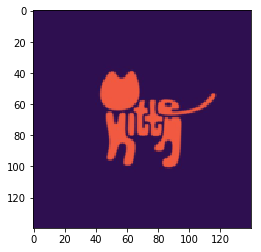

In [26]:
idx = 0

print(vocab.textify(caps[:,idx]))
plt.imshow(denorm(ims[idx]))

### Build the first model

In [250]:
vec_dict = pickle.load(open(seq_PATH/'vec_dict.pkl','rb'))

In [383]:
n_hid, n_layers = 400, 3
emb_sz = 300

In [384]:
from torchvision import models

In [385]:
def MLP(n_in, n_out, p=0.2):
    return nn.Sequential(
        Flatten(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    )

In [386]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, wordvecs, itos, emb_sz, out_seqlen, n_layers=2):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.device = device
        
        # Visual Encoder
        self.base_network = list(models.vgg16_bn(pretrained=True).children())[0][:-1]
        self.base_network.to(self.device)
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.MLP1 = MLP(1024, emb_sz)
        self.MLP2 = MLP(1024, emb_sz)
        self.MLP3 = MLP(1024, emb_sz)
        
        # Decoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(emb_sz, emb_sz, num_layers=n_layers, dropout=0.1)  # square to enable weight tying
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        
        
    def forward(self, inp):
        #pdb.set_trace()
        h = self.encode(inp)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        
        for i in range(self.out_seqlen):
            dec_output, h = self.decode(dec_inp, h)
            res.append(dec_output)
            dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
        
        return torch.stack(res)

    
    def encode(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = enc_output.view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        h1 = self.MLP1(enc_output)
        h2 = self.MLP2(enc_output)
        h3 = self.MLP3(enc_output)
        
        enc_output = torch.stack([h1, h2, h3], dim = 0)
        
        return enc_output
    
    def decode(self, dec_inp, h):
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once
        output, h = self.rnn_dec(emb_inp, h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h

In [387]:
imgCapGen = ImageCaptionGenerator(gpu, vec_dict, vocab.itos, emb_sz, 30, n_layers)

3689 ['xxup', 'xxrep', 'xxwrep', ':', "'s"]


In [391]:
learn.destroy()

this object has been destroyed


In [392]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))  # like bind in c++

In [393]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)

In [394]:
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=Seq2SeqLoss, callback_fns=ShowGraph)

In [491]:
for m in list(learn.model.base_network.children())[17:]:
    requires_grad(m, True)

In [492]:
for m in list(learn.model.base_network.children()):
    #requires_grad(m, False)
    #requires_grad(m, True)
    print(m,"\t\t\t", requires_grad(m))

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 			 False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 			 False
ReLU(inplace) 			 None
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 			 False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 			 False
ReLU(inplace) 			 None
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 			 None
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 			 False
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 			 False
ReLU(inplace) 			 None
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 			 False
BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 			 False
ReLU(inplace) 			 None
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 			 None
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 			 

In [524]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


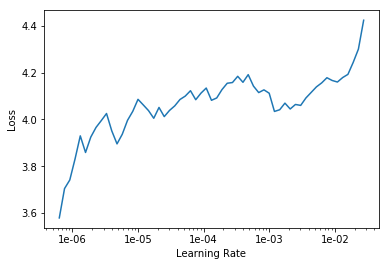

In [531]:
learn.recorder.plot(skip_end=2)

In [493]:
lr = 2e-3

epoch,train_loss,valid_loss,time
0,3.544247,3.570488,17:26


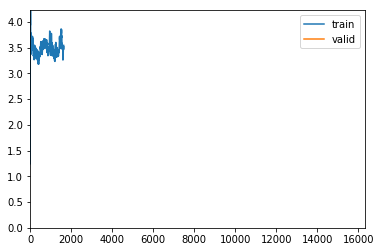

In [ ]:
learn.fit_one_cycle(10, lr)

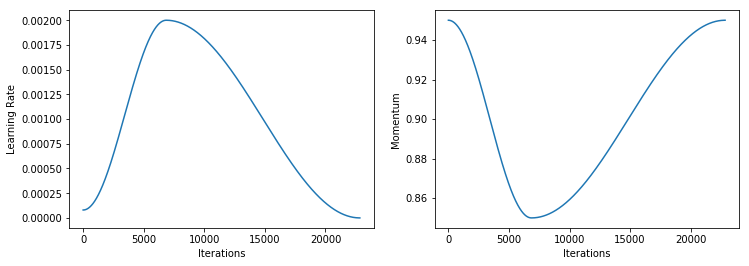

In [317]:
learn.recorder.plot_lr(show_moms=True)

In [404]:
learn.save("captionGenerator_1")

In [523]:
learn.model.train()

ImageCaptionGenerator(
  (base_network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [514]:
idx = 123

In [515]:
im = learn.data.train_ds[idx][0]

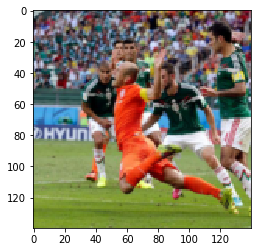

In [516]:
plt.imshow(denorm(im))

In [517]:
pred = learn.model(im.unsqueeze(0).to(gpu))

In [518]:
pred.shape

torch.Size([7, 1, 33465])

In [519]:
pred = pred.data.max(2)[1]

In [520]:
pred = pred.transpose_(0,1).data.cpu().numpy()

In [521]:
pred

array([[41, 34,  8,  8,  8,  8,  1]])

In [522]:
vocab.textify(pred[0])

'football player the the the the xxpad'